<a href="https://colab.research.google.com/github/soniapetrini/ADM_deep_learning/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: image classification
## Comics VS Real faces

In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import csv 
import time
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D

import matplotlib.pyplot as plt
import os
from tensorflow import keras

import cv2
from sklearn.model_selection import train_test_split
import pickle
import datetime
from multiprocessing import Pool
from google.colab import files

Insert your Kaggle credentials to download the data.

In [3]:
od.download('https://www.kaggle.com/datasets/defileroff/comic-faces-paired-synthetic-v2')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: soniapetrini
Your Kaggle Key: ··········


100%|██████████| 2.18G/2.18G [00:18<00:00, 125MB/s]


Our first step is to collect all the paths annotated with the related label in a dictionary, and to split them into training, validation, and test set. 

In [4]:
# preparation
common_dir = 'comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/'
classes = ['comics','faces']

# paths to all data
paths = {}    
for cl in classes:
  for f in os.listdir(common_dir+cl):
    paths[f'{common_dir}{cl}/{f}'] = classes.index(cl)

# labelled dataframe
data_df = pd.DataFrame.from_dict(paths, 'index', columns = ['label'])

# shuffle and split paths and labels
tf.random.set_seed(42)
data_df.sample(frac=1)
X = data_df.index
Y = data_df['label']

In [5]:
# split in train and test
paths_train_all, paths_test, Y_train_all, Y_test = train_test_split(X, Y, test_size=0.3)
# split train in train and valid
paths_train, paths_valid, Y_train, Y_valid       = train_test_split(paths_train_all, Y_train_all, test_size=0.3)

# Image transformation
The original images have size = 1024x1024 and are in color, the typical approach involves reducing RGB colors to gray, and rescale the gray tones between 0 and 1. We start with resizing the images to 64x64, and once we obtain a good performance we can try to work with a lower image resolution to see how it impacts the model.


In [6]:
def convert_paths_to_normalized_X(paths, size):
  X = []
  for p in paths:
    image   = cv2.imread(p, cv2.IMREAD_GRAYSCALE)                   # load image in greyscale
    resized = cv2.resize(image, size)/255                           # resize and normalize grey colors
    X.append(resized)

  return np.array(X).reshape(-1, size[0], size[1], 1)

size = (64,64)

Now we would like to know how much memory space do these objects use, as we are now dealing with "only" 2 GB of data, but if we want our programme to scale up we need to take both __time__ and __space__ into account. Indeed,processing an image takes some time, and thus we would like to only do this operation once, on all training, validation, and test data. However, we do not want to overload the memory, so, we first transform the validation set, which is the smallest of the three, and check its size in memory.

The set takes approximately 0,000152 MB, meaning that we can safely transform once also test and training sets without a memory overhead.

In [8]:
# transform all valid paths and labels in arrays
X_valid = convert_paths_to_normalized_X(paths_valid, size)                
Y_valid = np.array(Y_valid)
sys.getsizeof(X_valid)

152

In [9]:
X_train  = convert_paths_to_normalized_X(paths_train, size)
Y_train  = np.array(Y_train)
X_test   = convert_paths_to_normalized_X(paths_test, size)
Y_test   = np.array(Y_test)

In [10]:
# check all shapes
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(9800, 64, 64, 1)
(9800,)
(4200, 64, 64, 1)
(4200,)
(6000, 64, 64, 1)
(6000,)


# First model design

We can now work on the design of our architecture. Given the high number of possible tuning parameters in neural networks, we try to get an understanding of how different parameters combinations influence performance through a random search. The parameters we explore are:


*   size of the first Dense layer
*   type of pooling 
*   number of convolutional layers

Since this is an explorative search, we perform it on a subset of the data. Moreover, we parallelize the training and validation of the 6 nets



In [7]:
# ~ FUNCTIONS ~

# define model function
def build_model(input_shape, first_layer_size, which_pool, n_conv):

  model = Sequential()
  model.add(Dense(first_layer_size, activation = 'relu',input_shape = input_shape))             # fixed Dense layer

  if (which_pool == 'max'):                                                                     # pooling, max or average?
    pool_layer = MaxPooling2D(pool_size=(2, 2))
  else:
    pool_layer = AveragePooling2D(pool_size=(2, 2))

  if ( n_conv in [1,2] ):                                                                       # add convolution layers 
    model.add(Conv2D(32, (3, 3)))
    model.add(pool_layer)
  if ( n_conv in [2] ): 
    model.add(Conv2D(64, (3, 3)))
    model.add(pool_layer)

  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))                                                   # fixed final classification layer

  return model


# add f-score to history
def add_fscore(history):
  n_epochs = len(history['recall'])
  fscores     = []
  val_fscores = []
  for i in range(n_epochs):
    for which in ['val_','']:
      precision = history[f'{which}precision'][i]
      recall    = history[f'{which}recall'][i]
      fscore =  2 * (precision * recall) / (precision + recall)
      if which == '':
        fscores.append(fscore)
      else:
        val_fscores.append(fscore)

  history['f-score'] = fscores
  history['val_f-score'] = val_fscores
  return history


# plot selected model's history
def plot_history(net_name):
  history_ = pickle.load(open('/trainHistoryDict'+ net_name, "rb"))
  history_ = add_fscore(history_)

  f = plt.figure(figsize=(10,6))
  ax = f.add_subplot(121)
  ax2 = f.add_subplot(122)

  # loss
  ax.plot(history_['loss'])
  ax.plot(history_['val_loss'])
  ax.grid(True)
  ax.set_title("loss")
  ax.legend(['train', 'validation'], loc='upper right')

  # f-score
  ax2.plot(history_['f-score'])
  ax2.plot(history_['val_f-score'])
  ax2.grid(True)
  ax2.set_title("f-score")
  ax2.legend(['train', 'validation'], loc='lower right')


In [ ]:
# PERFORM RANDOM SEARCH IN PARALLEL!  

# subset data
X_train_s = X_train[:6000]
Y_train_s = Y_train[:6000]
X_valid_s = X_valid[:2000]
Y_valid_s = Y_valid[:2000]
input_shape       = X_train_s.shape[1:]

# search space
first_layer_sizes = [8, 16, 32]
which_pools       = ['average', 'max']
n_convs           = [1, 2]

# epochs
n_epochs = 25

# define list of unique args combinations
nets_names  = []
nets_args   = []
for pool in which_pools:
  while(len([el for el in nets_args if pool in el]) < 3):
    first_layer_size = random.choice(first_layer_sizes)
    which_pool       = random.choice(which_pools)
    n_conv           = random.choice(n_convs)
    net_name = f'{first_layer_size}_{which_pool}_{n_conv}'
    if net_name not in nets_names: 
      nets_names.append(net_name)
      nets_args.append([input_shape, first_layer_size, which_pool, n_conv, net_name])
print(nets_names)

# define function
def train_and_validate(arguments):

   input_shape, first_layer_size, which_pool, n_conv, net_name = arguments

   # build model
   model = build_model(input_shape, first_layer_size, which_pool, n_conv)
   model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Precision','Recall'])

   # train and validate it
   start = datetime.datetime.now()
   print(start)
   history = model.fit(X_train_s, Y_train_s, batch_size=50, epochs=n_epochs, validation_data=(X_valid_s,Y_valid_s))
   end = datetime.datetime.now()
   print(end)

   # write times to file
   filename = 'times.csv'
   file_exists = os.path.isfile(filename)
   with open(filename, "a") as time_f:
     writer = csv.DictWriter(time_f, fieldnames=['net','time'])
     if not file_exists:
       writer.writeheader()
     writer.writerow({'net':net_name, 'time':end-start})

   # write history to file
   with open('/trainHistoryDict' + net_name, 'wb') as history_f:
           pickle.dump(history.history, history_f)
         

def run_parallel(nets_args):
    pool = Pool(processes=len(nets_args))
    pool.map(train_and_validate, nets_args)

# run 
run_parallel(nets_args)

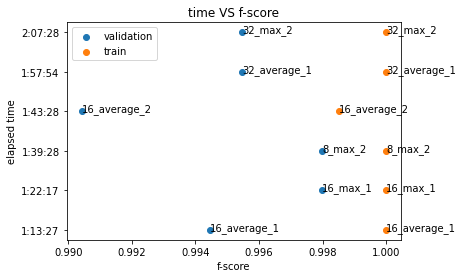

In [3]:
3 # PLOT TIME VS LAST f-score

# load df with names and times
#nets_df = pd.read_csv('times.csv')
nets_df = pd.read_csv('random_search_scores.csv')
nets_df['time'] = nets_df['time'].str[:7]


# # access last fscore
# last_train_fscores  = []
# last_val_fscores  = []
# for i, name in enumerate(nets_df['net']):
#     history = pickle.load(open('/trainHistoryDict'+ name, "rb"))
#     history = add_fscore(history)
#     last_val_fscores.append(history['val_f-score'][n_epochs-1])
#     last_train_fscores.append(history['f-score'][n_epochs-1])

# nets_df['val_f-score'] = last_val_fscores
# nets_df['train_f-score'] = last_train_fscores
# nets_df

# # save df with results
# nets_df.to_csv('random_search_scores.csv')
# files.download("random_search_scores.csv" )


# plot!
fig, ax = plt.subplots()

ax.scatter(nets_df['val_f-score'], nets_df['time'])
ax.scatter(nets_df['train_f-score'], nets_df['time'])
ax.set_title("time VS f-score")
ax.set_xlabel("f-score")
ax.set_ylabel("elapsed time")
ax.legend(['validation', 'train'])

for i, txt in enumerate(nets_df['net']):
    ax.annotate(txt, (nets_df['val_f-score'][i], nets_df['time'][i]))
    ax.annotate(txt, (nets_df['train_f-score'][i], nets_df['time'][i]))

plt.savefig('random_search_plot.pdf',bbox_inches = "tight")

'Average' pooling seems to overall perform worse than 'max', even if when fixing the number of neurons of the first Dense layer to 32, 'average' pooling with 1 convolutional layer yields virtually the same score as 'max' with 2 convolutional layers, and in less time. However, this worsening in performance with the addition of one convolutional layer is also observed when 'average' pooling is fixed and the first layer has 16 neurons. 

If we now focus on the nets with higher f-score on validation (16_max_1 and 8_max_2), we see how by balancing the neurons in the first layer and the number of convolutional layers they obtain the same f-score. Thus, the choice criterion that we use is based on elapsed time, which is lower for '16_max_1', meaning that we can obtain the same performance in less time by increasing the first layer neurons rather than the number of convolutional layers.


## Effect of size of performance
Thus, since with 16 neurons in the first dense layer, max pooling, and 1 convolutional layer we already obtain a very high accuracy, we can reduce the images to a smaller size, to see whether we can further reduce the space required to store the inputs in memory while keeping the same level of performance. This time we use the whole training set, and train for a longer time.

In [56]:
# SEARCH ON SIZE WITH FIXED MODEL
list_sizes = [(32,32), (64,64)]

first_layer_size = 16
which_pool = 'max'
n_conv = 1
n_epochs = 30

def resize_train_and_validate(size):
  net_name = f'{first_layer_size}_{which_pool}_{n_conv}_{size[0]}'

  # resize images
  X_train_f   = convert_paths_to_normalized_X(paths_train, size)
  Y_train_f   = np.array(Y_train)
  X_valid_f   = convert_paths_to_normalized_X(paths_valid, size)
  Y_valid_f   = np.array(Y_valid)

  # build model
  input_shape = X_train_f.shape[1:]
  model = build_model([input_shape,first_layer_size,which_pool,n_conv])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Precision','Recall'])

  # train and validate it
  start = time.time()
  history = model.fit(X_train_f, Y_train_f, batch_size=35,
                      epochs=n_epochs, validation_data=(X_valid_f,Y_valid_f))
  end = time.time()

  # write times to file
  filename = 'times.csv'
  file_exists = os.path.isfile(filename)

  with open(filename, "a") as time_f:
    writer = csv.DictWriter(time_f, fieldnames=['net','time'])
    if not file_exists:
      writer.writeheader()
    writer.writerow({'net':net_name, 'time':end-start})

  # write history to file
  with open('/trainHistoryDict' + net_name, 'wb') as history_f:
          pickle.dump(history.history, history_f)


# run training in parallel
def run_parallel(list_sizes):
    pool = Pool(processes=len(list_sizes))
    pool.map(resize_train_and_validate, list_sizes)

run_parallel(list_sizes)

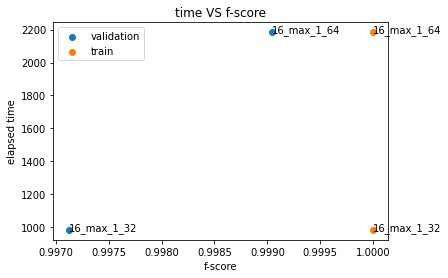

In [19]:
# load df with names and times
nets_df = pd.read_csv('times.csv')

# access last fscore
last_val_fscores  = []
last_train_fscores  = []
for i, name in enumerate(nets_df['net']):
    history = pickle.load(open('/trainHistoryDict'+ name, "rb"))
    history = add_fscore(history)
    last_val_fscores.append(history['val_f-score'][n_epochs-1])
    last_train_fscores.append(history['f-score'][n_epochs-1])

nets_df['val_f-score'] = last_val_fscores
nets_df['train_f-score'] = last_train_fscores

# # save df with results
nets_df.to_csv('size_search_scores.csv')
files.download("size_search_scores.csv" )

# plot!
fig, ax = plt.subplots()
ax.scatter(nets_df['val_f-score'], nets_df['time'])
ax.scatter(nets_df['train_f-score'], nets_df['time'])
ax.set_title("time VS f-score")
ax.set_xlabel("f-score")
ax.set_ylabel("elapsed time")
ax.legend(['validation', 'train'])

for i, txt in enumerate(nets_df['net']):
    ax.annotate(txt, (nets_df['val_f-score'][i], nets_df['time'][i]))
    ax.annotate(txt, (nets_df['train_f-score'][i], nets_df['time'][i]))

plt.savefig('size_search_plot.pdf', bbox_inches = "tight")

In [80]:
# compute time and fscore differences
perc_diffs = []
for col in ['time','val_f-score']:
  perc_diff = ( nets_df[col][1] - nets_df[col][0] ) / nets_df[col][1]
  perc_diffs.append(round(perc_diff,3))

print(f'By reducing size from (64,64) to (32,32), we reduce training time by {perc_diffs[0]} %, while losing only {perc_diffs[1]} % in f-score')

By reducing size from (64,64) to (32,32), we reduce training time by 0.549 %, while losing only 0.002 % in f-score


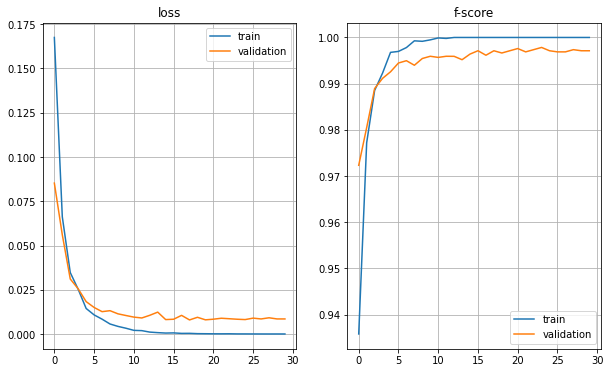

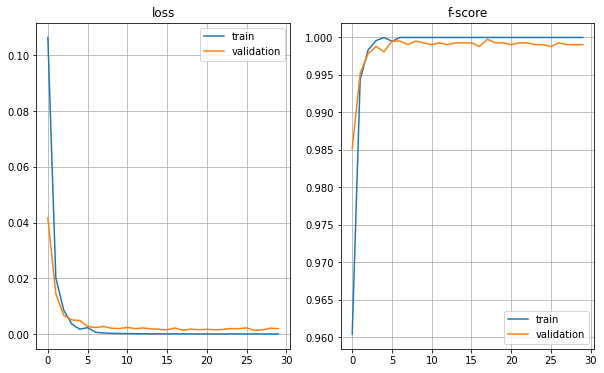

In [62]:
# save plots of histories
for i, name in enumerate(nets_df['net']):
    plot_history(name)
    plt.savefig(f'history_{name}.pdf')

## Test the chosen architecture
We can now test the best model according to our validation procedure on real unseen data. To do so, we train the model on the whole training set.

In [8]:
first_layer_size = 16
which_pool       = 'max'
n_conv           = 1
size             = (32,32)
n_epochs         = 30
net_name = f'{first_layer_size}_{which_pool}_{n_conv}_{size[0]}'

# resize images
X_train_f   = convert_paths_to_normalized_X(paths_train_all, size)
Y_train_f   = np.array(Y_train_all)
X_test_f    = convert_paths_to_normalized_X(paths_test, size)
Y_test_f    = np.array(Y_test)

In [27]:
# build model
input_shape = X_train_f.shape[1:]
model = build_model(input_shape,first_layer_size,which_pool,n_conv)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Precision','Recall'])

# train it
start = datetime.datetime.now()
print(f'start training at:{start}')

history = model.fit(X_train_f, Y_train_f, batch_size=35, epochs=n_epochs)

end   = datetime.datetime.now()
print(f'end training at:{end}')

# test it!
test_scores = model.evaluate(x = X_test_f, y = Y_test_f)

start training at:2022-06-08 08:20:51.023487
Epoch 1/30
400/400 [==============================] - 26s 64ms/step - loss: 0.1448 - precision: 0.9450 - recall: 0.9449
Epoch 2/30
400/400 [==============================] - 19s 47ms/step - loss: 0.0437 - precision: 0.9890 - recall: 0.9832
Epoch 3/30
400/400 [==============================] - 19s 48ms/step - loss: 0.0252 - precision: 0.9937 - recall: 0.9909
Epoch 4/30
400/400 [==============================] - 20s 49ms/step - loss: 0.0145 - precision: 0.9967 - recall: 0.9960
Epoch 5/30
400/400 [==============================] - 19s 47ms/step - loss: 0.0114 - precision: 0.9967 - recall: 0.9968
Epoch 6/30
400/400 [==============================] - 19s 47ms/step - loss: 0.0087 - precision: 0.9978 - recall: 0.9978
Epoch 7/30
400/400 [==============================] - 19s 47ms/step - loss: 0.0070 - precision: 0.9977 - recall: 0.9986
Epoch 8/30
400/400 [==============================] - 19s 47ms/step - loss: 0.0036 - precision: 0.9994 - recall: 0.

In [51]:
precision = round(test_scores[1], 4)
recall    = round(test_scores[2], 4)
f_score   = round( 2* ( precision * recall ) / (precision + recall) , 4 )
print(f'Test precision :{precision}')
print(f'Test recall    :{recall}')
print(f'Test f-score   :{f_score}')

Test precision :0.999
Test recall    :0.9967
Test f-score   :0.9978
